# Experiment for Dataset1

Author: Xiaolong Liu & Kedong Chen

Created: Nov 11, 2023

In [1]:
# import necessary package
import numpy as np
import pandas as pd
import phase2_py_moudule as phase2
# import some useful function from python files
import gradient_descent as gd

import torch
import torchvision
import torchvision.datasets as datasets

import matplotlib.pyplot as plt

# 1: DataSet $1$ (nPentaneIsopentane):

### We build functions to get trainloader and testloader(use the sources in programming assignment $5$). Then we can use them to implement SGD.

In [2]:
def get_train_test_loader(trainset, testset, batch_size = 1, random_seed = 123):
    """
    inputs: 
        trainset: train data (from torchvision)
        testset: test data (from torchvision)
        batch_size: number of data points in a batch
        random_seed: random seed to make the results reproducible
    returns: 
        trainloader: iteratable object with batches of train data
        testloader: iteratable object with batches of test data
    """
    torch.manual_seed(random_seed)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size,
                                              shuffle = True)
    testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size,
                                             shuffle = False)
    
    return (trainloader, torch.tensor(trainset)), (testloader, torch.tensor(testset))

### This function is just used to paste features and label which will be convenient to use.

In [3]:
def paste(z,y):
    """
    inputs:
        z: an array
        y: an array
    returns:
        modified_arrays: concat two arrays
    """
    modified_arrays = []
    for i, array in enumerate(z):
        if i < len(y):
            new_array = np.append(array, y[i])
        else:
            new_array = array
        
        modified_arrays.append(new_array)
        
    return modified_arrays

### Then we build the problem class(use the sources in programming assignment $3$). The details of problem setting can be found in our report.

In [4]:
class FirstProblem():
    '''
    Implementation of the objective function:
    ||Y - (x1*x3*(z2 - (z3 / 1.632))) / (1+x2*z1+x3*z2+x4*z3)|| ** 2

    Parameters:
        x1: scalar parameter, see formula
        x2: scalar parameter, see formula
        x3: scalar parameter, see formula
        x4: scalar parameter, see formula
    '''

    def __init__(self):
        '''
        Initialization.
        Here we do not add any special initializations, because we want to use dataloader and something else.
        '''
    
    def M(self, x, data):
        """
        Summary:
            Calculate the M according to the formula, which is the prediction of Y
            Here M is a vector, the ith component the the model m(x, z) of the ith observation
        Args:
            x: an array
            data: an array(matrix)
        Returns:
            M: an array
        """
        Z = data[:, 0:3]
        
        return (x[0]*x[2]*(Z[:,1] - Z[:,2] / 1.632)) / (1 + x[1]*Z[:,0] + x[2]*Z[:,1] + x[3]*Z[:,2])
    
    def value(self, x, data):
        '''
        Summary:
            Compute value of the objective function(loss function) based on x and data
        Args:
            x: an array
            data: an array(matrix)
        Returns:
            val: a float number
        '''
        
        Y = data[:, -1]
        val =  np.mean((Y - self.M(x, data))**2)
        
        return val
    
    def M_derivative(self, x, data):
        """
        Summary:
            Calculate the partial derivative(w.r.t. x_1, x_2, x_3, x_4) of M
            Return a matrix that the ith column is the partial derivative of M w.r.t. x_i
        Args:
            x: an array
            data: an array(matrix)
        Returns:
            derivative: an array(matrix)
        """
        Z = data[:,0:3]
        Y = data[:,-1]
        
        denominator = (Z[:, 0] * x[1] + x[3]*Z[:, 2] + x[2]*Z[:, 1] + 1)
        numerator_x1 = x[2] * (Z[:, 1] - Z[:, 2] / 1.632)
        
        numerator_x2 = -1*x[0]*x[2]*Z[:, 0]*(Z[:, 1] - Z[:, 2] / 1.632)
        
        numerator_x3 = -1*x[0]*(Z[:, 2]/1.632-Z[:, 1])*(x[3]*Z[:, 2]+x[1]*Z[:, 0]+1)
        
        numerator_x4 = -1*x[0]*x[2]*Z[:, 2]*(Z[:, 1] - Z[:, 2] / 1.632)
        
        derivative = np.array([
            numerator_x1 / denominator,
            numerator_x2 / denominator**2,
            numerator_x3 / denominator**2,
            numerator_x4 / denominator**2
        ])
        
        return derivative
    
    def gradient(self, x, data):
        """
        Summary: 
            Here we calculate the gradient of the objective function(loss function), which can be calculate by chain rule.
            See the report to get the details.
        Args:
            x: an array
            data: an array(matrix)
        Returns:
            grad: an array
        """
        
        Z = data[:,0:3]
        Y = data[:,-1]

        grad = -2/data.shape[0] * (Y - self.M(x, data)).dot(self.M_derivative(x, data).T)
        
        return grad
    
    def starting_point(self):
        '''
        Summary: 
            Here we provide a alternative starting point
        Returns:
            x_start: an array
        '''
        x_start = np.array([10., 10.,10.,10.])
        
        return x_start

## Experiments

### Setting up. 
#### Here we use .CsvDataSet in programming assignment $6$ to split data into training dataset and test dataset.
####  But for this dataset, we do not split data into training dataset and test dataset(although we have realized it). The reason is that we only have one prediction model(which is given from teacher), so there’s no need to use test dataset to compare (there’s no ’compare’). 

#### Of course, we can see the performance of this single model, but since our dataset size is very small (only 24 observations), we do not decide to do so. 

#### The norm we used here is infinity norm, which means 
$$
\|x\|_{\infty} = \max_{i} |x_{i}|
$$


#### here | · | means absolute value.

In [5]:
# Import dataset
nPI_df = pd.read_csv('nPentaneIsopentane.csv')
# Split the dataset to training set and test set
dataset = phase2.CsvDataSet('nPentaneIsopentane.csv', frac_test=0, rand_seed=0, add_dummy_feature=False)

## Gradient Descent

#### First we set $\text{batch_size} = 24$, which is the data size. So this means we are using normal gradient descent.
#### We choose step size as $0.01$, tolenrance as $0.001$, starting point as $[1,1,1,1]$

In [6]:
prob = FirstProblem()

### Experiment $1$

#### We choose step size as 0.01, tolerance as 0.001, starting point as [1, 1, 1, 1]. The result is as following:

In [7]:
# Using get_train_test_loader to make batches of the training set and test set.
trainloader, testloader = get_train_test_loader(paste(dataset._Z_train, dataset._y_train),
                                                paste(dataset._Z_test, dataset._y_test),batch_size = 24)

options = gd.init_options()
options['step_size'] = 0.01
options['output_level'] = 1
options['max_iter'] = 100000
options['tol'] = 0.001
options['test'] = 0
options['print'] = 1

status_1, x_sol_1, f_sol_1, record_1 = gd.minimize(prob, options, trainloader, testloader, x_start = np.array([1,1,1,1]))
x_sol_1

Running gradient descent method with step size              0.01

Number of iterations............: 100000
Final objective.................: 0.140753
||grad|| at final point.........: 0.00344226
Status: Maximum number of iterations (100000) exceeded.


array([30.39528849,  0.94344655,  0.59592664,  2.10019606])

#### It exceeded the limit of the iterations. But the loss is quite low(In fact, this is close to the best critical value we have found, so it is low. We will see it later). Then we plot the norm of gradient against epoch. Overall, the curve is going down:

In [9]:
plt.plot(np.log(record_1['norm_grad_batch'][:]))
plt.title("log Norm of gradient for each epoch")
plt.xlabel("Epoch")
plt.show()

#### Then we zoom in and see the first one hundred epochs, we find that between 20th to 60th, the norm  of gradient have raised and then going down. It is not always going down.

In [9]:
plt.plot(record_1['norm_grad_batch'][:99])
plt.title("Norm of gradient for each epoch(1 to 100)")
plt.xlabel("Epoch")
plt.show()

#### Then we plot the loss of objective function against epoch. Overall, the curve is going down:

In [10]:
plt.plot(np.log(record_1['loss_batch']))
plt.title("log Loss of objective function for each epoch")
plt.xlabel("Epoch")
plt.show()

#### Then we zoom in and see the first one hundred epochs. Of course, the loss is keep going down (because this is gradient descent, we expect to see that).

In [11]:
plt.plot(np.log(record_1['loss_batch'][:99]))
plt.title("log Loss of objective function for each epoch(1 to 100)")
plt.xlabel("Epoch")
plt.show()

### Experiment $2$

#### Since Experiment 1 exceed the limit. We choose step size as 0.1, tolerance as 0.001,starting point as $[1, 1, 1, 1]$, hoping to have a quick convergence. The result is as following, it still exceed the limit, and loss is similar to first one:

In [12]:
# Using get_train_test_loader to make batches of the training set and test set.
trainloader, testloader = get_train_test_loader(paste(dataset._Z_train, dataset._y_train),
                                                paste(dataset._Z_test, dataset._y_test),batch_size = 24)

options = gd.init_options()
options['step_size'] = 0.1
options['output_level'] = 1
options['max_iter'] = 100000
options['tol'] = 0.001
options['test'] = 0
options['print'] = 1

status_2, x_sol_2, f_sol_2, record_2 = gd.minimize(prob, options, trainloader, testloader, x_start = np.array([1,1,1,1]))
x_sol_2

Running gradient descent method with step size              0.1

Number of iterations............: 100000
Final objective.................: 0.135873
||grad|| at final point.........: 0.0362503
Status: Maximum number of iterations (100000) exceeded.


array([33.51663875,  2.24394323,  1.25058858,  5.23629088])

#### Then we plot the norm of gradient against epoch, which is quite normal (around 6000th there are some small fluctuations):

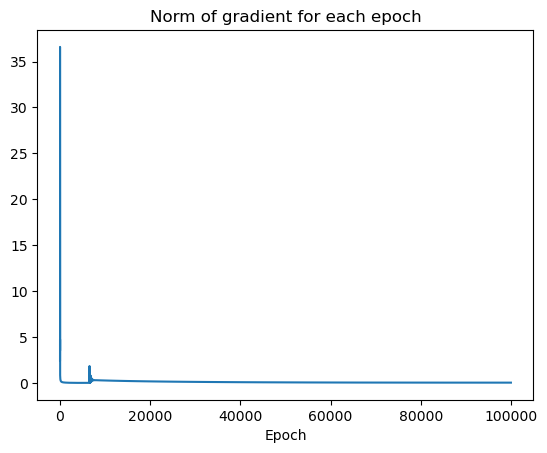

In [13]:
plt.plot(record_2['norm_grad_batch'][:])
plt.title("Norm of gradient for each epoch")
plt.xlabel("Epoch")
plt.show()

#### Then we plot the loss of objective function against epoch. Overall, the curve is going down, wihch is also normal:

In [14]:
plt.plot(record_1['loss_batch'])
plt.title("Loss of objective function for each epoch")
plt.xlabel("Epoch")
plt.show()

### Experiment $3$

#### We just want to have a try what if we choose step size as 0.05, tolerance as 0.001, starting point as [1, 1, 1, 1]. It find the critical point, although it takes 42700 iterations, the loss is quite similar too previous points but the parameters are quite different (except x1). We doubt if these two are two different stationary points. The result is as following:

In [12]:
# Using get_train_test_loader to make batches of the training set and test set.
trainloader, testloader = get_train_test_loader(paste(dataset._Z_train, dataset._y_train),
                                                paste(dataset._Z_test, dataset._y_test),batch_size = 24)

options = gd.init_options()
options['step_size'] = 0.05
options['output_level'] = 1
options['max_iter'] = 100000
options['tol'] = 0.001
options['test'] = 0
options['print'] = 1

status_3, x_sol_3, f_sol_3, record_3 = gd.minimize(prob, options, trainloader, testloader, x_start = np.array([1,1,1,1]))
x_sol_3

Running gradient descent method with step size              0.05

Number of iterations............: 42700
Final objective.................: 0.136511
||grad|| at final point.........: 0.000999952
Status: Critical point found.


array([32.26373346, -3.35963557, -1.96171687, -7.70961666])

#### Then we plot the norm of gradient against epoch. It still very normal:

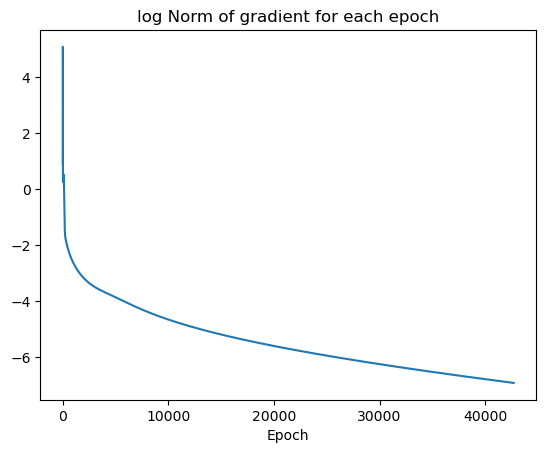

In [13]:
plt.plot(np.log(record_3['norm_grad_batch'][:]))
plt.title("log Norm of gradient for each epoch")
plt.xlabel("Epoch")
plt.show()

#### Then we plot the loss of objective function against epoch. It also very normal:

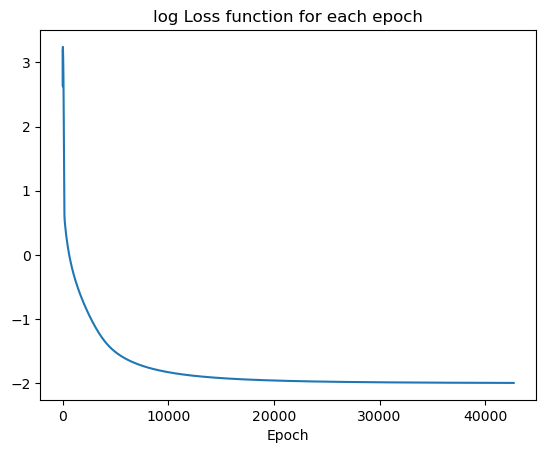

In [30]:
plt.plot(np.log(record_3['loss_batch'][:]))
plt.title("log Loss function for each epoch")
plt.xlabel("Epoch")
plt.show()

#### If we look close, the loss raise up at very beginning then goes down. Maybe that's why it found another stationary point(and the reason why it raised maybe is because the step size is a little big).

In [31]:
plt.plot(np.log(record_3['loss_batch'][:499]))
plt.title("log Loss function for each epoch(First 500 epoch)")
plt.xlabel("Epoch")
plt.show()

### Experiment $4$

#### Next we change starting point to [−1,−1,−1,−1]. It converges quickly, but it seems to converges to a stationary point we are not interested (which is definitely not the minimum of the objective function) and the absolute value of parameters becomes quite big, and we choose step size as 0.1, tolerance as 0.001, the result is as following:

In [16]:
# Using get_train_test_loader to make batches of the training set and test set.
trainloader, testloader = get_train_test_loader(paste(dataset._Z_train, dataset._y_train),
                                                paste(dataset._Z_test, dataset._y_test),batch_size = 24)

options = gd.init_options()
options['step_size'] = 0.1
options['output_level'] = 1
options['max_iter'] = 100000
options['tol'] = 0.001
options['test'] = 0
options['print'] = 1

status_4, x_sol_4, f_sol_4, record_4 = gd.minimize(prob, options, trainloader, testloader, x_start = np.array([-1,-1,-1,-1]))
x_sol_4

Running gradient descent method with step size              0.1

Number of iterations............: 3074
Final objective.................: 0.912881
||grad|| at final point.........: 0.000997948
Status: Critical point found.


array([   46.87009956, -2893.26855656,  -646.54235746,  -260.87046558])

#### We can see the parameters are extremely large, especially x2. Let us figure out what happens? Plot the norm of gradient for first 100 epochs. We can find there’s a very huge value of gradient exists at 17th epoch which is around 28940.

#### Let’s remove it first and see other norms in first 100 epochs. We can see before 17th, the norm somehow raised after several epochs and at 17th epoch, it changes a lot and then decrease again.

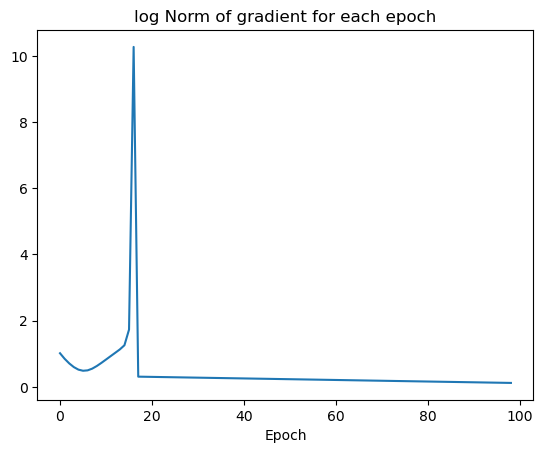

The norm of gradient at 17th epoch: 28940.3740190072


In [17]:
plt.plot(np.log(record_4['norm_grad_batch'][0:99]))
plt.title("log Norm of gradient for each epoch")
plt.xlabel("Epoch")
plt.show()
print(f"The norm of gradient at 17th epoch: {record_4['norm_grad_batch'][16]}")

#### Let’s remove it first and see other norms in first 100 epochs. We can see before 17th, the norm somehow raised after several epochs and at 17th epoch, it changes a lot and then decrease again.

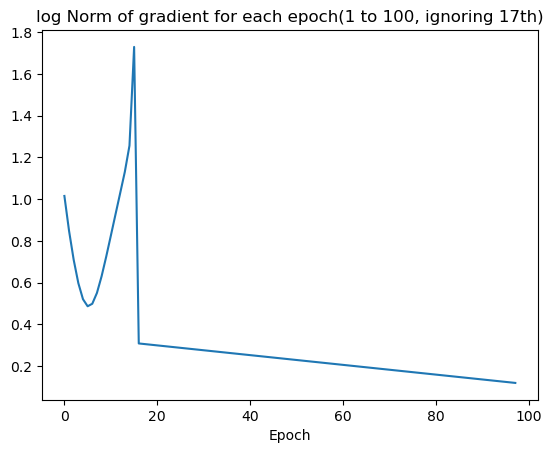

In [18]:
plt.plot(np.log(record_4['norm_grad_batch'][:16] + record_4['norm_grad_batch'][17:99]))
plt.title("log Norm of gradient for each epoch(1 to 100, ignoring 17th)")
plt.xlabel("Epoch")
plt.show()

#### Let's remove $17\text{th}$ epoch and see all other norms. We can see the norm decrease almost all the time. So that's why at last our parameters have such a huge values. This is because the $17\text{th}$ epoch moves them far from the beginning.

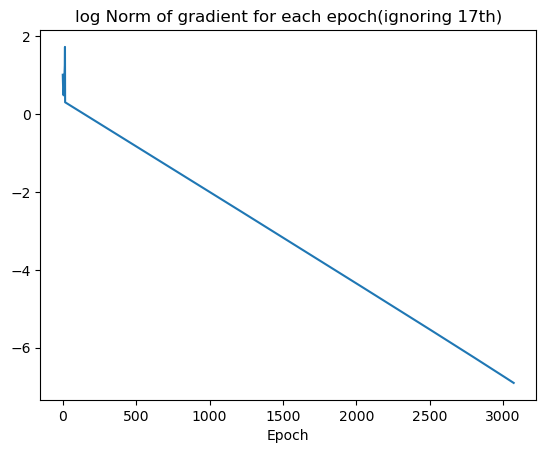

In [19]:
plt.plot(np.log(record_4['norm_grad_batch'][:16] + record_4['norm_grad_batch'][17:]))
plt.title("log Norm of gradient for each epoch(ignoring 17th)")
plt.xlabel("Epoch")
plt.show()

#### And for the same reason the loss of objective also have a huge ’jump’.

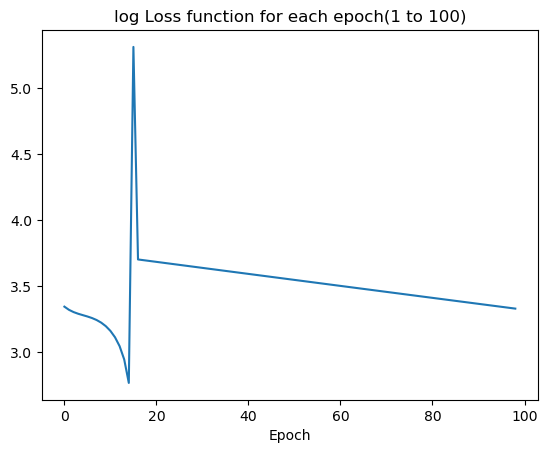

In [32]:
plt.plot(np.log(record_4['loss_epoch'][0:99]))
plt.title("log Loss function for each epoch(1 to 100)")
plt.xlabel("Epoch")
plt.show()

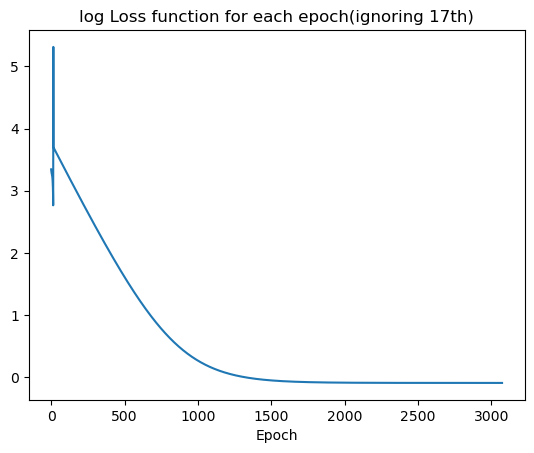

In [33]:
plt.plot(np.log(record_4['loss_epoch'][:16] + record_4['loss_epoch'][17:]))
plt.title("log Loss function for each epoch(ignoring 17th)")
plt.xlabel("Epoch")
plt.show()

#### We think this is because the step size is too big for this starting point, so at 17th epoch it just jumped over the local minimum and the destination is to steep.

### Experiment $5$

#### So we change step size to 0.01, it exceeded the maximum limit of iterations. But the result shows that it approached to the stationary point that we are interested (based on other experiments):

#### We change step size to $0.01$, it exceeded the maximum limit of iterations. But the result shows that it approached to the (loacl)minimum (based on other experiments).

In [25]:
# Using get_train_test_loader to make batches of the training set and test set.
trainloader, testloader = get_train_test_loader(paste(dataset._Z_train, dataset._y_train),
                                                paste(dataset._Z_test, dataset._y_test),batch_size = 24)

options = gd.init_options()
options['step_size'] = 0.01
options['output_level'] = 1
options['max_iter'] = 100000
options['tol'] = 0.001
options['test'] = 0
options['print'] = 1

status_5, x_sol_5, f_sol_5, record_5 = gd.minimize(prob, options, trainloader, testloader, x_start = np.array([-1,-1,-1,-1]))
x_sol_5

Running gradient descent method with step size              0.01

Number of iterations............: 100000
Final objective.................: 0.141266
||grad|| at final point.........: 0.384449
Status: Maximum number of iterations (100000) exceeded.


array([30.14437104, -0.61569538, -0.38756181, -1.3684173 ])

#### We plot the norm of gradient against epoch, there’s still a big ’jump’, but much smaller than the abnormal one in Experiment 4:

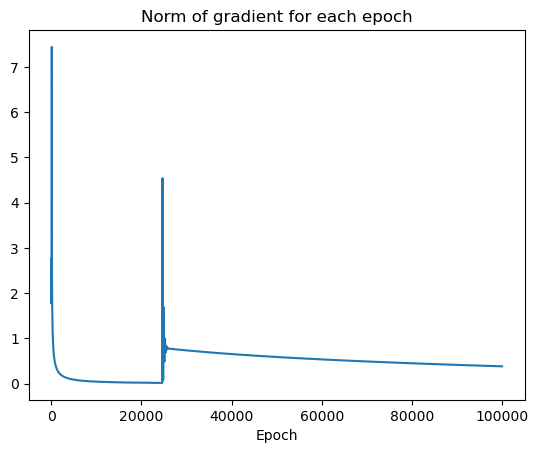

In [26]:
plt.plot(record_5['norm_grad_batch'][:])
plt.title("Norm of gradient for each epoch")
plt.xlabel("Epoch")
plt.show()

#### And in the plot of loss of objective function, we can see the loss is keep going down:

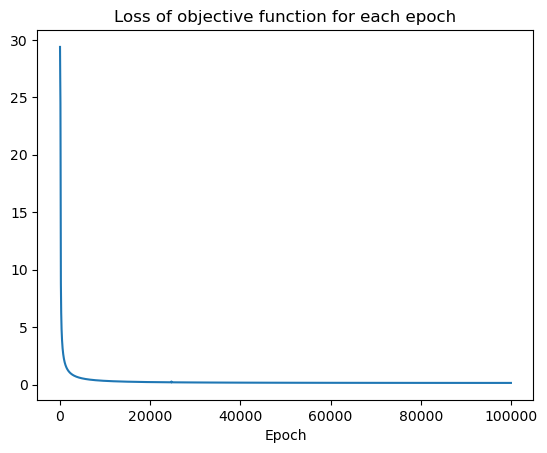

In [27]:
plt.plot(record_5['loss_batch'][:])
plt.title("Loss of objective function for each epoch")
plt.xlabel("Epoch")
plt.show()

### Experiment $6$

#### We change starting point to [−1, 2,−1,−1], step size to 0.05, it finally converges. And the loss result is close to the Experiment 3:

In [28]:
# Using get_train_test_loader to make batches of the training set and test set.
trainloader, testloader = get_train_test_loader(paste(dataset._Z_train, dataset._y_train),
                                                paste(dataset._Z_test, dataset._y_test),batch_size = 24)

options = gd.init_options()
options['step_size'] = 0.05
options['output_level'] = 1
options['max_iter'] = 100000
options['tol'] = 0.001
options['test'] = 0
options['print'] = 1

status_6, x_sol_6, f_sol_6, record_6 = gd.minimize(prob, options, trainloader, testloader, x_start = np.array([-1,2,-1,-1]))
x_sol_6

Running gradient descent method with step size              0.05

Number of iterations............: 41753
Final objective.................: 0.13652
||grad|| at final point.........: 0.000999995
Status: Critical point found.


array([32.25577353, -2.60153809, -1.51923569, -5.97106396])

#### The norm of gradient and the loss of objective is quite normal, so we just plot them:

In [29]:
plt.plot(record_6['norm_grad_batch'][:])
plt.title("Norm of gradient for each epoch")
plt.xlabel("Epoch")
plt.show()

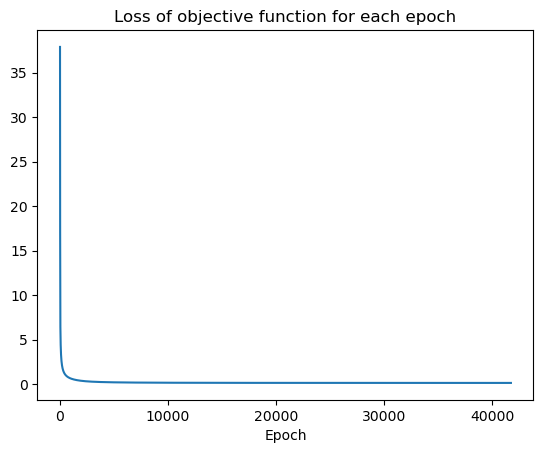

In [30]:
plt.plot(record_6['loss_batch'][:])
plt.title("Loss of objective function for each epoch")
plt.xlabel("Epoch")
plt.show()

## Stochastic Gradient Descent

#### Now we move to SGD part.

### Experiment $7$

#### First, we set batch size = 3, step size = 0.05. It converged and found the minimum, while normal Gradient descent didn’t find (with the same configuration):

In [31]:
# Using get_train_test_loader to make batches of the training set and test set.
trainloader, testloader = get_train_test_loader(paste(dataset._Z_train, dataset._y_train),
                                                paste(dataset._Z_test, dataset._y_test),batch_size = 3)

options = gd.init_options()
options['step_size'] = 0.05
options['output_level'] = 1
options['max_iter'] = 100000
options['tol'] = 0.001
options['test'] = 0
options['print'] = 1

status_7, x_sol_7, f_sol_7, record_7 = gd.minimize(prob, options, trainloader, testloader, x_start = np.array([1,1,1,1]))
x_sol_7

Running gradient descent method with step size              0.05

Number of iterations............: 10366
Final objective.................: 0.136207
||grad|| at final point.........: 0.000963121
Status: Critical point found.


array([32.63322884,  5.01507291,  2.8818361 , 11.44459333])

#### Let’s see the plot the norm of gradient against epoch, we can see the norm of gradient for each batch is fluctuating which is a property of SGD:

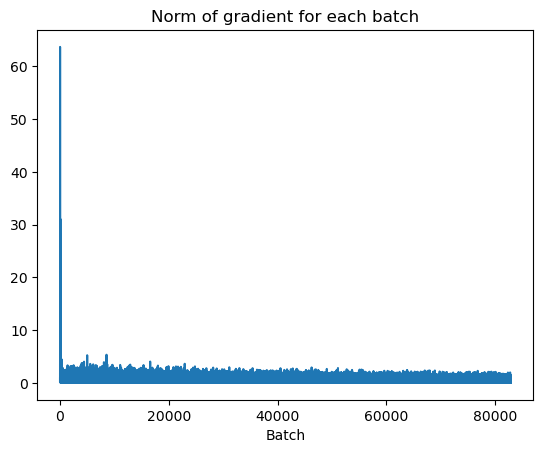

In [32]:
plt.plot(record_7['norm_grad_batch'][:])
plt.title("Norm of gradient for each batch")
plt.xlabel("Batch")
plt.show()

#### Overall the loss of objective function is also going down:

In [33]:
plt.plot(record_7['loss_batch'][:])
plt.title("Loss of objective function for each batch")
plt.xlabel("Batch")
plt.show()

#### If we look more close, we can see the loss also fluctuates:

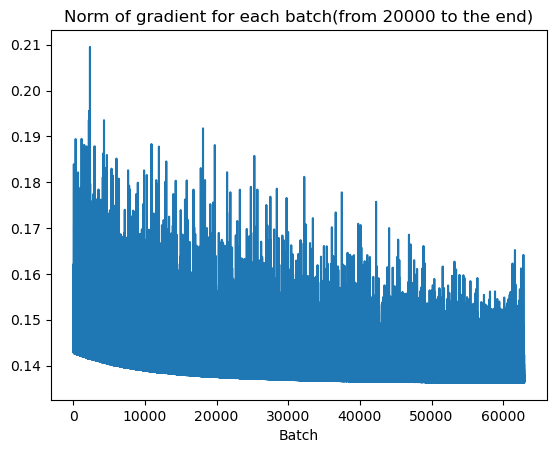

In [34]:
plt.plot(record_7['loss_batch'][20000:])
plt.title("Norm of gradient for each batch(from 20000 to the end)")
plt.xlabel("Batch")
plt.show()

### Experiment $8$

#### We change starting point to [−1,−1,−1,−1]. It converges much more faster. And it found the minimum:

In [23]:
# Using get_train_test_loader to make batches of the training set and test set.
trainloader, testloader = get_train_test_loader(paste(dataset._Z_train, dataset._y_train),
                                                paste(dataset._Z_test, dataset._y_test),batch_size = 3)

options = gd.init_options()
options['step_size'] = 0.05
options['output_level'] = 1
options['max_iter'] = 100000
options['tol'] = 0.001
options['test'] = 0
options['print'] = 1

status_8, x_sol_8, f_sol_8, record_8 = gd.minimize(prob, options, trainloader, testloader, x_start = np.array([-1,-1,-1,-1]))
x_sol_8

Running gradient descent method with step size              0.05

Number of iterations............: 9800
Final objective.................: 0.136242
||grad|| at final point.........: 0.000992228
Status: Critical point found.


array([32.59139294,  4.94776544,  2.84726597, 11.27715515])

#### Here’s the plot of the norm of gradient and the loss of objective function against batch:

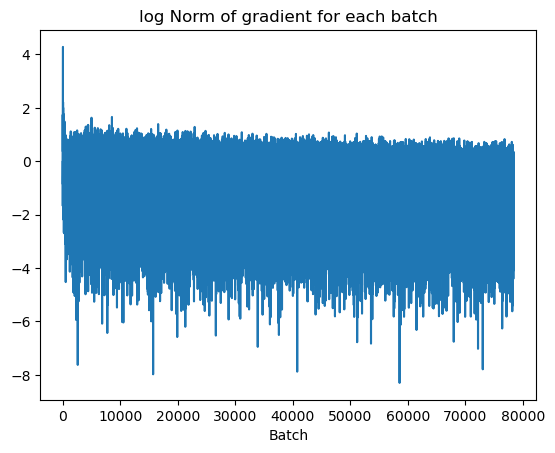

In [24]:
plt.plot(np.log(record_8['norm_grad_batch'][:]))
plt.title("log Norm of gradient for each batch")
plt.xlabel("Batch")
plt.show()

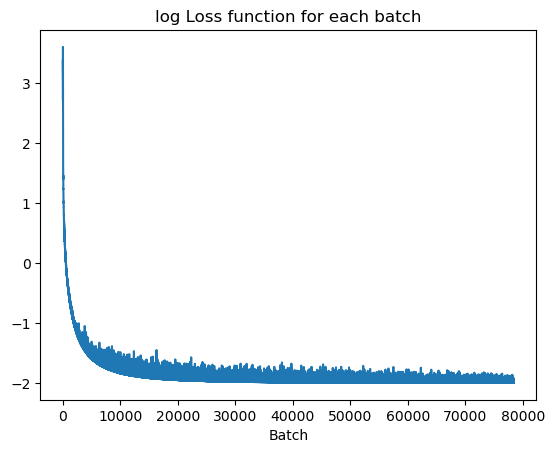

In [34]:
plt.plot(np.log(record_8['loss_batch'][:]))
plt.title("log Loss function for each batch")
plt.xlabel("Batch")
plt.show()

### Experiment $9$

#### We change batch size to 6 and change step size to 0.01 (because if we choose 0.05 it faces same issue with Experiment 4). After a long training, it convergences to another local minimum, which achieves the similar loss.

In [26]:
# Using get_train_test_loader to make batches of the training set and test set.
trainloader, testloader = get_train_test_loader(paste(dataset._Z_train, dataset._y_train),
                                                paste(dataset._Z_test, dataset._y_test),batch_size = 6)

options = gd.init_options()
options['step_size'] = 0.01
options['output_level'] = 1
options['max_iter'] = 100000
options['tol'] = 0.001
options['test'] = 0
options['print'] = 1

status_9, x_sol_9, f_sol_9, record_9 = gd.minimize(prob, options, trainloader, testloader, x_start = np.array([-1,-1,-1,-1]))
x_sol_9

Running gradient descent method with step size              0.01

Number of iterations............: 59551
Final objective.................: 0.136698
||grad|| at final point.........: 0.000999595
Status: Critical point found.


array([ 32.09742163,  -7.02313947,  -4.12654881, -16.03614023])

#### It stills have a very large gradient norm, which is similar to Experiment 4. But thanks for the randomness from the SGD, it finally ’escape’ from this, find the right way and achieves very low loss:

In [28]:
plt.plot(np.log(record_9['norm_grad_batch'][:150]))
plt.title("log Norm of gradient for each batch(First 150 Batch)")
plt.xlabel("Batch")
plt.show()
print(f"The norm of gradient at 142th epoch: {record_9['norm_grad_batch'][141]}")

The norm of gradient at 142th epoch: 1754.2840649156124


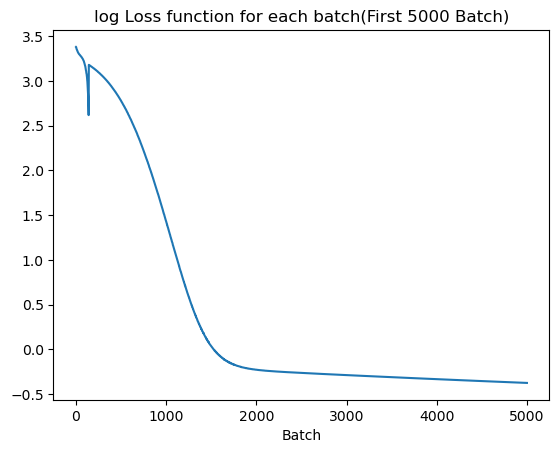

In [35]:
plt.plot(np.log(record_9['loss_batch'][:4999]))
plt.title("log Loss function for each batch(First 5000 Batch)")
plt.xlabel("Batch")
plt.show()

## More Observations and Comparison

#### We believe this is enough for the Experiment Part. Let's move to the Comparison Part.

#### First, we find that there are several different points that achieves similar loss (Experiment 2, Experiment 3, Experiment 6, Experiment 7/8, Experiment 9), so there are several stationary points for this objective function that achieves same level loss (which is low). 
#### Both two optimization methods achieves same level of loss (if we choose suitable configuration), so we mainly compare their convergence rates.

#### We choose the best performance for each method, which is Experiment 3 and Experiment 8.

### Convergence rate with normal issue.
#### We choose the best performance for each method, which is Experiment 3 and Experiment 8. First let’s compare the convergence rate based on epoch level (first 5000 epochs). We can find SGD convergence more quickly than GD:

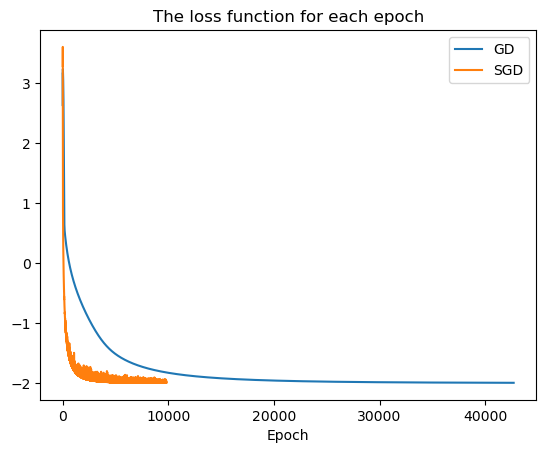

In [39]:
plt.plot(np.log(record_3['loss_epoch']), label="GD")
plt.plot(np.log(record_8['loss_epoch']), label="SGD")
plt.legend()
plt.title("The loss function for each epoch")
plt.xlabel("Epoch")
plt.show()

#### Next let’s compare the convergence rate based on batch level, which means we compare each update of two methods.

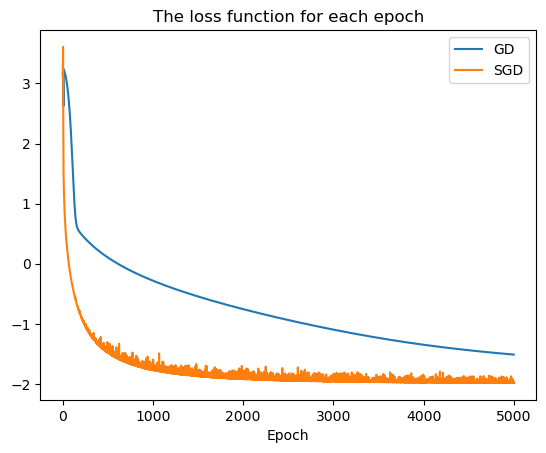

In [41]:
plt.plot(np.log(record_3['loss_epoch'][:5000]), label="GD")
plt.plot(np.log(record_8['loss_epoch'][:5000]), label="SGD")
plt.legend()
plt.title("The loss function for each epoch")
plt.xlabel("Epoch")
plt.show()

#### Next let's compare the convergence rate based on batch level, which means we compare each update of two methods.

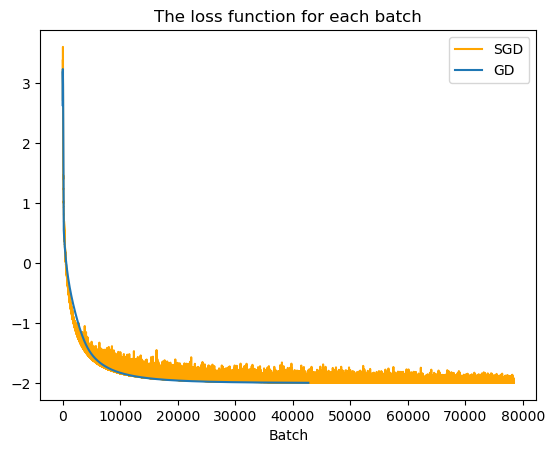

In [51]:
plt.plot(np.log(record_8['loss_batch'][:]), label="SGD", color="orange")
plt.plot(np.log(record_3['loss_batch'][:]), label="GD")
plt.legend()
plt.title("The loss function for each batch")
plt.xlabel("Batch")
plt.show()

#### Let’s have a look more closely (first 1000 epochs). We can find SGD fluctuated up and down. After around 100 updates it decreased. At first several updates GD also has an abnormal raise of loss, which shouldn’t happen. We think this is because the step size is a little bit big for that point, and after it GD performed normally.Based on batch level, SGD still decreased faster than GD and achieves lower loss before GD(See the lines after 600).

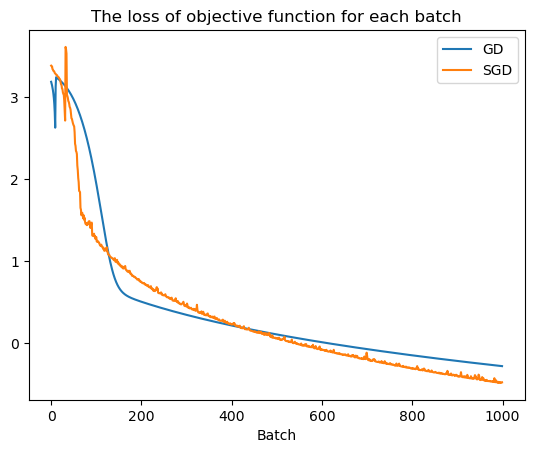

In [43]:
plt.plot(np.log(record_3['loss_batch'][:1000]), label="GD")
plt.plot(np.log(record_8['loss_batch'][:1000]), label="SGD")
plt.legend()
plt.title("The loss of objective function for each batch")
plt.xlabel("Batch")
plt.show()

### Convergence rate with abnormal issue. 
#### We also want to compare two methods on the abnormal cases, which is Experiment 4 and Experiment 9. We can see a little ”jump” around 20 of the blue line. This is the abnormal point we mentioned in Experiment 4. Orange one decrease faster than Blue one.

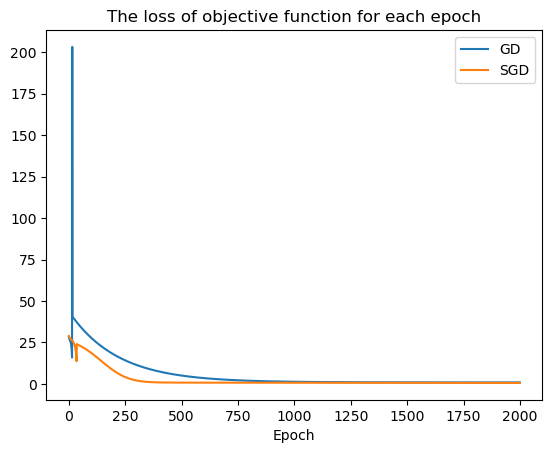

In [45]:
plt.plot(record_4['loss_epoch'][:2000], label="GD")
plt.plot(record_9['loss_epoch'][:2000], label="SGD")
plt.legend()
plt.title("The loss of objective function for each epoch")
plt.xlabel("Epoch")
plt.show()

#### We can see a little "jump" around 150 of the orange line. This is the abnormal point we mentioned in Experiment $9$. Blue one is somehow more quick decrease than orange.

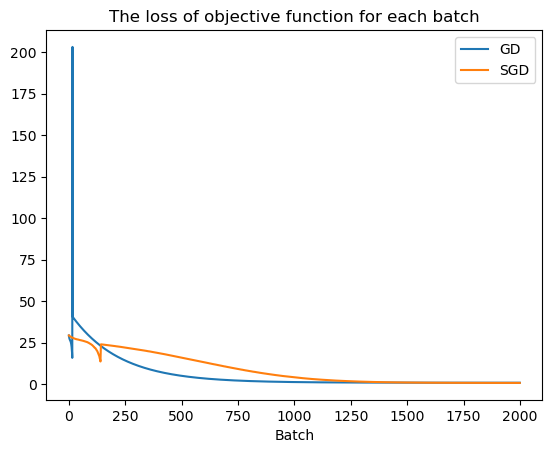

In [46]:
plt.plot(record_4['loss_batch'][:2000], label="GD")
plt.plot(record_9['loss_batch'][:2000], label="SGD")
plt.legend()
plt.title("The loss of objective function for each batch")
plt.xlabel("Batch")
plt.show()

## Conclusion

### The comparative analysis reveals that Stochastic Gradient Descent reaches the desired tolerance level more rapidly than Gradient Descent, particularly when evaluated over epochs. However, at the batch level, Gradient Descent exhibits a more consistent and rapid decrease, indicating better stability and efficiency in each update.

### This comparison suggests a trade-off: while GD provides more stability and requires higher computational resources, SGD, on the other hand, demonstrates quicker convergence but with less stability. Additionally, from the observations in Experiments 2 and 4, it is evident that SGD has the ability to escape from atypical positions and find critical points, a feat that GD struggles with. This highlights the adaptive nature of SGD in navigating complex optimization landscapes, making it a suitable choice in scenarios where rapid convergence is prioritized over computational efficiency.